import all the necesarry library

In [432]:
import numpy as np
import pywt
import os
import cv2
import matplotlib.pyplot as plt
from PIL import Image
import math
from scipy.fftpack import dct
from scipy.fftpack import idct

from typing import List

In [433]:
maxVal = 63 # 0-255 -> valeur dans l'image
DctCoef = [3,3] # 0-8 -> coefficient de la DCT à utiliser
#todo : key à ajouter

image = "original/lena.jpg"
#image = "original/python.png"
marque = "original/marque.png"
texte = """Lorem ipsum dolor sit amet, consectetur adipiscing elit. In facilisis venenatis tellus, vitae tempus lectus commodo sed. Donec nec arcu augue. Donec porttitor molestie lectus, blandit fermentum dui aliquet nec. Ut egestas magna vitae enim porttitor consequat. Aliquam ac gravida ex. Sed id justo et metus iaculis pharetra. Sed eu volutpat ligula.

Vivamus et facilisis tellus. Donec eget porta erat, ac bibendum purus. Nullam ac purus massa. Proin varius dapibus elementum. Donec feugiat nisi lobortis purus efficitur, fermentum pulvinar eros hendrerit. Fusce consectetur volutpat odio, ac tincidunt tortor aliquet et. Nam ex dolor, suscipit sit amet felis eget, porttitor ultricies velit. Proin consequat velit arcu, non fermentum nibh tincidunt sit amet. Aliquam in quam ac enim sollicitudin feugiat. Aliquam ut eleifend turpis, vitae ultricies tortor. Vivamus ligula nibh, sodales at dolor eget, imperdiet vehicula elit.

Nullam a ipsum non neque laoreet feugiat. Aenean ornare posuere sagittis. Orci varius natoque penatibus et magnis dis parturient montes, nascetur ridiculus mus. Suspendisse libero nulla, ultricies non molestie ac, tristique non nisl. Class aptent taciti sociosqu ad litora torquent per conubia nostra, per inceptos himenaeos. Phasellus molestie id ex in gravida. Ut feugiat maximus ligula, eget ullamcorper nisi mollis ut. Aenean nisl augue, accumsan et quam ac, ornare fermentum neque. Etiam condimentum nibh non tincidunt mollis. Praesent mattis laoreet felis a elementum. Nunc eget sem molestie, aliquet ante quis, ullamcorper dui. Nunc consectetur tortor vel sapien maximus, sit amet rutrum lectus sagittis. Maecenas id fermentum tortor. Ut interdum mauris sed imperdiet porttitor.

Aliquam eleifend lobortis diam quis vulputate. Curabitur ut maximus risus. Quisque et orci fringilla, hendrerit velit sit amet, porta purus. Duis cursus pulvinar elit, vitae sodales tortor. Pellentesque a tincidunt tortor. Sed eu diam a orci luctus porttitor quis iaculis tortor. Ut ac auctor enim. Donec venenatis tortor quis augue placerat."""

texte = "Test d'insertion de text  !"

# Functions 

Function Convert and resize image 

In [434]:
def convertImage(imageName, size):
    img = Image.open(imageName).resize((size, size), 1) 

    # Convert RGB image to YCbCr
    img = img.convert('YCbCr')
    # Split the YCbCr image into Y, Cb and Cr channels
    colors = img.split()
    # Convert the channel to a numpy array
    y = np.array(colors[0])
    Cb = np.array(colors[1])
    Cr = np.array(colors[2])
    img = y
    
    # Convert the numpy array to a PIL image
    img = Image.fromarray(img)
    imageArray = np.array(img.getdata(), dtype=float).reshape((size, size))
    return imageArray, colors



def convertMark(imageName, size):
    mark = Image.open(imageName).resize((size, size), 1)
    # Convert RGB image to gray scale
    mark = mark.convert('L')
    # Converting the gray scale image to binary image
    mark = mark.point(lambda x: 0 if x < 128 else maxVal, '1')
    # Inverting the binary image if there are more 255s than 0s
    #if (np.sum(mark) > (size * size / 2)):
        #mark = mark.point(lambda x: 0 if x == maxVal else maxVal, '1')

    markArray = np.array(mark.getdata(), dtype=float).reshape((size, size))
    return markArray

Convert text

In [435]:
#image = "original/image.jpg"
#texte = "Test d'insertion de texte  !"

def utf8_to_binary_matrix(text: str) -> np.ndarray:
    # Convert the text to a bytearray in UTF-8 encoding
    byte_array = bytearray(text.encode("utf-8"))

    # Convert each byte to binary and concatenate them into a string
    binary_string = "".join(f"{byte:08b}" for byte in byte_array)

    # Calculate the number of rows needed based on the maximum of 128 columns per row
    num_rows = (len(binary_string) + 127) // 128

    # Create a numpy matrix array with the binary data, padded with zeros if necessary
    binary_matrix = np.zeros((num_rows, 128), dtype=int)
    for i in range(num_rows):
        start = i * 128
        end = start + 128
        binary_matrix[i][:len(binary_string[start:end])] = list(map(int, binary_string[start:end]))
    
    # Convert 1 to 255 and 0 to 0    
    binary_matrix = binary_matrix * (maxVal*3.6)

    return binary_matrix


def binary_list_to_utf8(binary_list: List[int]) -> str:
    # Inverse the conversion of 1 to 255 and 0 to 0
    binary_list = [0 if x < (maxVal*2.3) else 1 for x in binary_list]
    # Convert the binary list to a binary string
    binary_string = "".join(map(str, binary_list))

    # Convert the binary string to a bytearray and then to a string in UTF-8 encoding
    byte_array = bytearray(int(binary_string[i:i+8], 2) for i in range(0, len(binary_string), 8))
    
    # Convert the binary string to a bytearray and then to a string in UTF-8 encoding,
    # replacing unknown characters with a dash
    try:
        byte_array = bytearray(int(binary_string[i:i+8], 2) for i in range(0, len(binary_string), 8))
        text = byte_array.decode("utf-8", errors="strict")
    except UnicodeDecodeError as e:
        byte_array = bytearray(int(binary_string[i:i+8], 2) if binary_string[i:i+8] != "00000000" else 45 for i in range(0, len(binary_string), 8))
        text = byte_array.decode("utf-8", errors="replace")

    return text




binText = utf8_to_binary_matrix(texte)
print(binText)

# Convert the numpy array back to a flatten list of integers 0 or 1
liste = [int(j) for j in binText.flatten()] 
print((liste))

print(binary_list_to_utf8(liste))

[[  0.  226.8   0.  226.8   0.  226.8   0.    0.    0.  226.8 226.8   0.
    0.  226.8   0.  226.8   0.  226.8 226.8 226.8   0.    0.  226.8 226.8
    0.  226.8 226.8 226.8   0.  226.8   0.    0.    0.    0.  226.8   0.
    0.    0.    0.    0.    0.  226.8 226.8   0.    0.  226.8   0.    0.
    0.    0.  226.8   0.    0.  226.8 226.8 226.8   0.  226.8 226.8   0.
  226.8   0.    0.  226.8   0.  226.8 226.8   0.  226.8 226.8 226.8   0.
    0.  226.8 226.8 226.8   0.    0.  226.8 226.8   0.  226.8 226.8   0.
    0.  226.8   0.  226.8   0.  226.8 226.8 226.8   0.    0.  226.8   0.
    0.  226.8 226.8 226.8   0.  226.8   0.    0.    0.  226.8 226.8   0.
  226.8   0.    0.  226.8   0.  226.8 226.8   0.  226.8 226.8 226.8 226.8
    0.  226.8 226.8   0.  226.8 226.8 226.8   0. ]
 [  0.    0.  226.8   0.    0.    0.    0.    0.    0.  226.8 226.8   0.
    0.  226.8   0.    0.    0.  226.8 226.8   0.    0.  226.8   0.  226.8
    0.    0.  226.8   0.    0.    0.    0.    0.    0.  226.8 226.8 22

(128*128)/8 = 2048 caracters can be embedded in an image

Lorem ipsum dolor sit amet, consectetur adipiscing elit. In facilisis venenatis tellus, vitae tempus lectus commodo sed. Donec nec arcu augue. Donec porttitor molestie lectus, blandit fermentum dui aliquet nec. Ut egestas magna vitae enim porttitor consequat. Aliquam ac gravida ex. Sed id justo et metus iaculis pharetra. Sed eu volutpat ligula.

Vivamus et facilisis tellus. Donec eget porta erat, ac bibendum purus. Nullam ac purus massa. Proin varius dapibus elementum. Donec feugiat nisi lobortis purus efficitur, fermentum pulvinar eros hendrerit. Fusce consectetur volutpat odio, ac tincidunt tortor aliquet et. Nam ex dolor, suscipit sit amet felis eget, porttitor ultricies velit. Proin consequat velit arcu, non fermentum nibh tincidunt sit amet. Aliquam in quam ac enim sollicitudin feugiat. Aliquam ut eleifend turpis, vitae ultricies tortor. Vivamus ligula nibh, sodales at dolor eget, imperdiet vehicula elit.

Nullam a ipsum non neque laoreet feugiat. Aenean ornare posuere sagittis. Orci varius natoque penatibus et magnis dis parturient montes, nascetur ridiculus mus. Suspendisse libero nulla, ultricies non molestie ac, tristique non nisl. Class aptent taciti sociosqu ad litora torquent per conubia nostra, per inceptos himenaeos. Phasellus molestie id ex in gravida. Ut feugiat maximus ligula, eget ullamcorper nisi mollis ut. Aenean nisl augue, accumsan et quam ac, ornare fermentum neque. Etiam condimentum nibh non tincidunt mollis. Praesent mattis laoreet felis a elementum. Nunc eget sem molestie, aliquet ante quis, ullamcorper dui. Nunc consectetur tortor vel sapien maximus, sit amet rutrum lectus sagittis. Maecenas id fermentum tortor. Ut interdum mauris sed imperdiet porttitor.

Aliquam eleifend lobortis diam quis vulputate. Curabitur ut maximus risus. Quisque et orci fringilla, hendrerit velit sit amet, porta purus. Duis cursus pulvinar elit, vitae sodales tortor. Pellentesque a tincidunt tortor. Sed eu diam a orci luctus porttitor quis iaculis tortor. Ut ac auctor enim. Donec venenatis tortor quis augue placerat.

Generated 4 paragraphs, 299 words, 2048 bytes of Lorem Ipsum

Function that embedded watermark image into cover image

In [436]:
# Embed watermark into the cover image
def embedWatermark(watermarkArray, originalImage):
    watermarkArraySize = len(watermarkArray[0])
    watermarkFlat = watermarkArray.ravel() # ravel() is used to convert 2D array to 1D array
    ind = 0

    for x in range (0, len(originalImage), 8):
        for y in range (0, len(originalImage), 8):
            if ind < len(watermarkFlat): 
                subdct = originalImage[x:x+8, y:y+8]
                # Embed the fingerprint pixels into mid-Highfrequency cell of the 8x8 block.
                subdct[DctCoef[0]][DctCoef[1]] = watermarkFlat[ind]
                originalImage[x:x+8, y:y+8] = subdct
                ind+= 1
    return originalImage

Function that apply Discrete Cosine Transform on an 8x8 block

In [437]:
# DCT transform on image, i.e. image array
def applyDCT(imageArray):
    size = len(imageArray[0])
    allSubdct = np.empty((size, size))
    for i in range (0, size, 8):
        for j in range (0, size, 8):
            subpixels = imageArray[i:i+8, j:j+8]
            subdct = dct(dct(subpixels.T, norm="ortho").T, norm="ortho")
            allSubdct[i:i+8, j:j+8] = subdct
    return allSubdct


Function that apply Inverse Discrete Cosine Transform on an 8x8 block

In [438]:
def inverseDCT(allSubdct):
    size = len(allSubdct[0])
    allSubidct = np.empty((size, size))
    for i in range (0, size, 8):
        for j in range (0, size, 8):
            subidct = idct(idct(allSubdct[i:i+8, j:j+8].T, norm="ortho").T, norm="ortho")
            allSubidct[i:i+8, j:j+8] = subidct

    return allSubidct


Function that extract watermark image from embedded image

In [439]:
def getWatermark(dctWatermarkedCoeff, watermarkSize):
    subwatermarks = []
    for x in range (0, len(dctWatermarkedCoeff), 8):
        for y in range (0, len(dctWatermarkedCoeff), 8):
            coeffSlice = dctWatermarkedCoeff[x:x+8, y:y+8]
            subwatermarks.append(coeffSlice[DctCoef[0]][DctCoef[1]])
    watermark = np.array(subwatermarks).reshape(watermarkSize, watermarkSize)
    return watermark

Function that recover watermark image using 2 key

In [440]:
def recoverWatermark(image, outputImageName=None):
    coeffsWatermarkedImage=list(pywt.wavedec2(data = image, wavelet = 'haar', level = 1))
    dctWatermarkedCoeff = applyDCT(coeffsWatermarkedImage[0])
    watermarkArray = getWatermark(dctWatermarkedCoeff, 128)
    watermarkArray =  np.uint8(watermarkArray)
    
    watermarkArray = threshold(watermarkArray)
    
    #Save result
    img = Image.fromarray(watermarkArray)
    if (outputImageName != None):
        img.save('result/' + outputImageName+'.png')
    else :
        img.save('result/recoveredWatermark.png')
    return watermarkArray

def recoverText(image, output=None):
    coeffsWatermarkedImage=list(pywt.wavedec2(data = image, wavelet = 'haar', level = 1))
    dctWatermarkedCoeff = applyDCT(coeffsWatermarkedImage[0])
    
    # Fonction getText à ajouter ! pour retourner une liste et la bonne taille 
    watermarkArray = getWatermark(dctWatermarkedCoeff, 128)
    
    
    watermarkArray = [int(j) for j in watermarkArray.flatten()] 
    watermarkArray = binary_list_to_utf8(watermarkArray)
    
    # Look for dash in the text to know where the watermark ends if 3 dashes are found next to each other cut the text
    dashCount = 0
    for i in range (0, len(watermarkArray)-1, 1):
        if watermarkArray[i] == '-':
            dashCount += 1
        else:
            dashCount = 0
        if dashCount == 3:
            watermarkArray = watermarkArray[:i-2]
            break
        
    
    #Save result in txt file
    if (output != None):
        file = open('result/' + output+'.txt', 'w')
        file.write(watermarkArray)
        file.close()
    else :
        file = open('result/recoveredText.txt', 'w')
        file.write(watermarkArray)
        file.close()
    return watermarkArray

Function for save image

In [441]:
def printImage(imageArray, name):
    imageArrayCopy = imageArray.clip(0, 255)
    imageArrayCopy = imageArrayCopy.astype("uint8")
    img = Image.fromarray(imageArrayCopy)
    img.save('result/' + name)

Function that embedded watermark image into cover
image

In [442]:
def embeddedImage(coverImage, watermarkImage):
    imageArray, colors = convertImage(coverImage, 2048)
    watermarkArray = convertMark(watermarkImage, 128)
    np.set_printoptions(threshold=np.inf)

    coeffsImage = list(pywt.wavedec2(data=imageArray, wavelet = 'haar', level = 1))
    dctArray = applyDCT(coeffsImage[0]) # [0] corresponds to cH subband (cH = LH)
    dctArray = embedWatermark(watermarkArray, dctArray)

    coeffsImage[0] = inverseDCT(dctArray)
    imageArrayH=pywt.waverec2(coeffsImage, 'haar')
    
    # Get Y Cb Cr channels
    y, Cb, Cr = colors
    # Convert the numpy array back to an image
    y = Image.fromarray(imageArrayH.astype('uint8'))

    # Put the red channel back in the RGB image
    colors = (y, Cb, Cr)

    # Save result
    img = Image.merge('YCbCr', colors).convert('RGB')
    img.save('result/watermarkedImage.jpg')
    img.save('result/watermarkedImage.png')
    
    return img


def embeddedTexte(coverImage,texte):
    imageArray, colors = convertImage(coverImage, 2048)
    texteArray = utf8_to_binary_matrix(texte)

    np.set_printoptions(threshold=np.inf)



    coeffsImage = list(pywt.wavedec2(data=imageArray, wavelet = 'haar', level = 1))
    dctArray = applyDCT(coeffsImage[0])
    dctArray = embedWatermark(texteArray, dctArray)

    coeffsImage[0] = inverseDCT(dctArray)
    imageArrayH=pywt.waverec2(coeffsImage, 'haar')
    
    # Get Y Cb Cr channels
    y, Cb, Cr = colors
    # Convert the numpy array back to an image
    y = Image.fromarray(imageArrayH.astype('uint8'))

    # Put the red channel back in the RGB image
    colors = (y, Cb, Cr)

    # Save result
    img = Image.merge('YCbCr', colors).convert('RGB')
    img.save('result/watermarkedImage.jpg')
    img.save('result/watermarkedImage.png')
    
    return img

In [443]:
# Place à 0 les valeurs inférieures à 30 et place à 255 les valeurs supérieures à 225 puis séparation à 128
def threshold(image):
    #image[image < 15] = 0
    #image[image > 240] = 0
    image[image > 128] = 255
    image[image < 128] = 0
    return image

In [444]:
# Reducteur de bruit de la marque binaire extrait de l'image
def denoise(image):
    image = cv2.medianBlur(image, 5) #
    return image

# Testing

In [456]:
#watermarkeImage = embeddedImage("lena.png","logo.png") 
#watermarkeImage = embeddedImage(image,marque) 
watermarkeImage = embeddedTexte(image,texte) 

In [457]:
watermarkeImage = cv2.imread("result/watermarkedImage.jpg")
watermarkeImage = cv2.cvtColor(watermarkeImage, cv2.COLOR_BGR2YCrCb)
watermarkeImage = watermarkeImage.astype(np.float32)
y = watermarkeImage[:,:,0]
Cb = watermarkeImage[:,:,1]
Cr = watermarkeImage[:,:,2]

""" # Read the image in CbCr color space
# Convert RGB image to YCbCr
watermarkeImage = watermarkeImage.convert('YCbCr')
# Split the YCbCr image into Y, Cb and Cr channels
colors = watermarkeImage.split()
# Convert the channel to a numpy array
y = np.array(colors[0])
Cb = np.array(colors[1])
Cr = np.array(colors[2]) """


# Select the channel
watermarkeImage = y
#watermarkArray = recoverWatermark(watermarkeImage)
watermarkArray = recoverText(watermarkeImage)
print(watermarkArray)

# Correction de la compression jpeg du watermark récupéré
#watermarkArray = jpegCorrection(watermarkArray)

Test d'insertion de text  !                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            

# Plot all three resultant image

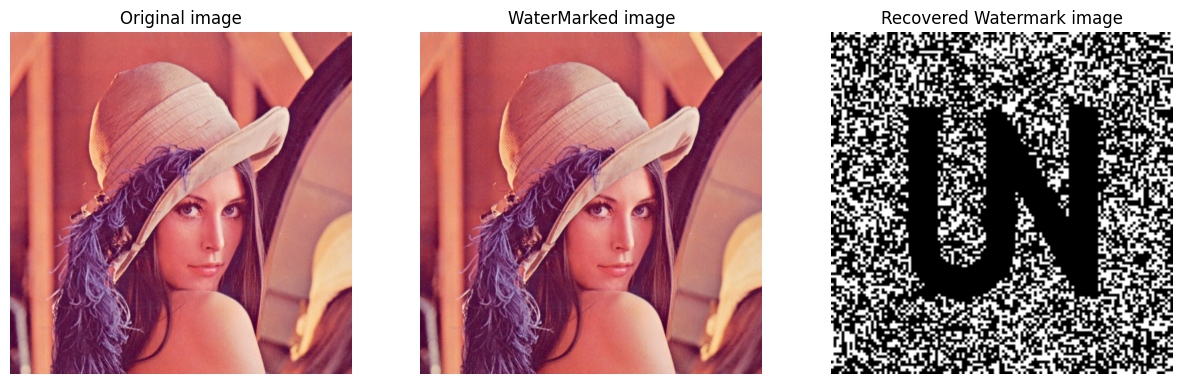

In [447]:
import matplotlib.pyplot as plt
import cv2

readImage = cv2.imread(image, cv2.COLOR_BGR2RGB)
waterimg = cv2.imread("result/watermarkedImage.jpg")
recovwater = cv2.imread("result/recoveredWatermark.png")

plt.figure(figsize = (15,15))
plt.subplot(1,3,1),plt.imshow(cv2.cvtColor(readImage, cv2.COLOR_BGR2RGB)),plt.title("Original image"), plt.axis('off')
plt.subplot(1,3,2),plt.imshow(cv2.cvtColor(waterimg, cv2.COLOR_BGR2RGB)),plt.title("WaterMarked image"), plt.axis("off")
plt.subplot(1,3,3),plt.imshow(recovwater),plt.title("Recovered Watermark image"), plt.axis("off")
plt.show()

---

# Calculate PSNR value

In [448]:
def pastingImage (img1, img2):
    temp = img2.copy()
    x_offset=y_offset=50
    img2[y_offset:y_offset+img1.shape[0], x_offset:x_offset+img1.shape[1]] = img1
    
    return img2, temp

In [449]:
def compute_psnr(img1, img2):
    
    img1 = img1.astype(float) / 255.
    img2 = img2.astype(float) / 255.
    mse = np.mean((img1 - img2) ** 2)
    if mse == 0:
        return "Same Image"
    return 10 * math.log10(1. / mse)

In [450]:
def NCC(img1, img2):
    return abs(np.mean(np.multiply((img1-np.mean(img1)),(img2-np.mean(img2))))/(np.std(img1)*np.std(img2)))

In [451]:
img1 = cv2.imread("original/image.jpg",0)
img1 = cv2.resize(img1, (512, 512))
img2 = cv2.imread("result/watermarkedImage.jpg",0)
img1, img2 = pastingImage(img1,img2)

psnr = compute_psnr(img1, img2)
print (f'PSNR value of resultant image is {psnr}')

PSNR value of resultant image is 22.892100344963225


In [452]:
print (f'Normalized cross correlation is {NCC(img1, img2)}')

Normalized cross correlation is 0.9337286145052051


# Attacks (Geometric & Signal Processing)

In [453]:
def noisy(noise_typ,image):
    if noise_typ == "gauss":
        row,col= image.shape
        mean = 0
        #var = 0.001
        var = 0.1
        sigma = var**0.5
        gauss = np.random.normal(mean,sigma,(row,col))
        gauss = gauss.reshape(row,col)
        #noisy = image + gauss
        noisy = image + image * gauss
        return noisy
    elif noise_typ == "s&p":
        row,col = image.shape
        s_vs_p = 0.5
        #amount = 0.01 # 0.10% of pixels ?
        amount = 0.0001
        out = np.copy(image)
        # Salt mode
        num_salt = np.ceil(amount * image.size * s_vs_p)
        coords = [np.random.randint(0, i - 1, int(num_salt))
                for i in image.shape]
        out[coords] = 1

        # Pepper mode
        num_pepper = np.ceil(amount* image.size * (1. - s_vs_p))
        coords = [np.random.randint(0, i - 1, int(num_pepper))
                for i in image.shape]
        out[coords] = 0
        return out
    elif noise_typ == "poisson":
        vals = len(np.unique(image)) 
        vals = 2 ** np.ceil(np.log2(vals))
        #noisy = np.random.poisson(image * vals) / float(vals) 
        noisy = np.random.poisson(image * vals) / float(vals) * 3
        return noisy
    elif noise_typ =="speckle":
        row,col = image.shape
        gauss = np.random.randn(row,col)
        gauss = gauss.reshape(row,col)        
        #noisy = image + image * gauss
        noisy = image + image * gauss*0.3
        return noisy
    elif noise_typ == "rotate90" :
        angle = 90
        scale = 1.0
        w = image.shape[1]
        h = image.shape[0]
        rangle = np.deg2rad(angle)  # angle in radians
        nw = (abs(np.sin(rangle) * h) + abs(np.cos(rangle) * w)) * scale
        nh = (abs(np.cos(rangle) * h) + abs(np.sin(rangle) * w)) * scale
        rot_mat = cv2.getRotationMatrix2D((nw * 0.5, nh * 0.5), angle, scale)
        rot_move = np.dot(rot_mat, np.array(
            [(nw - w) * 0.5, (nh - h) * 0.5, 0]))
        rot_mat[0, 2] += rot_move[0]
        rot_mat[1, 2] += rot_move[1]
        noisy=cv2.warpAffine(image, rot_mat, (int(math.ceil(nw)), int(math.ceil(nh))), flags=cv2.INTER_LANCZOS4)
        return noisy
    elif noise_typ=="chop30":
        img = image.copy()
        w, h = img.shape[:2]
        noisy=img[int(w * 0.3):, :]
        return noisy
    
    elif noise_typ=="jpeg":
        # encode image as a jpeg with quality 50
        encode_param = [int(cv2.IMWRITE_JPEG_QUALITY), 50]
        result, encimg = cv2.imencode('.jpg', image, encode_param)
        # decode image
        decimg = cv2.imdecode(encimg, 1)
        decimg = cv2.cvtColor(decimg, cv2.COLOR_BGR2RGB)
        decimg = cv2.cvtColor(decimg, cv2.COLOR_RGB2GRAY)
        return decimg


In [454]:
def restoreCrop(img):
    # Add null information to the borders of a cropped image to make it 2048x2048 in size:
    # Get the dimensions of the cropped image
    height, width = img.shape

    # Create a new black image of size 2048x2048
    new_img = np.zeros((2048, 2048), dtype=np.uint8)

    # Calculate the position to place the cropped image in the center of the new image
    x_offset = int((2048 - width) / 2)
    y_offset = int((2048 - height) / 2)

    # Add the cropped image to the center of the new image
    new_img[y_offset:y_offset+height, x_offset:x_offset+width] = img

    return new_img

+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
				 Compression Attacks
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++




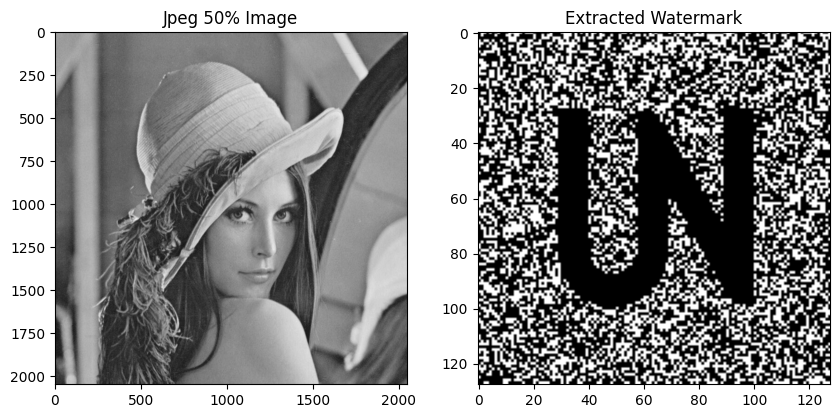

+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
				 Geometric Attacks
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


				 Rotate 90°
-----------------------------------------------------------------------------------------


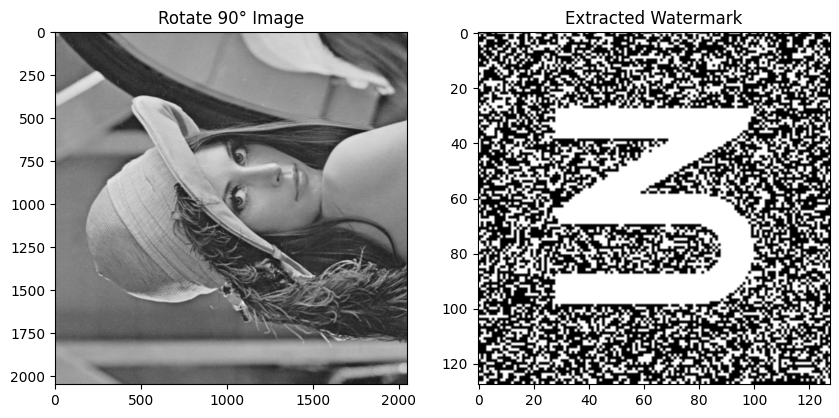

			 Normalized cross correlation is  0.9305154
******************************************************************************************
				 Chop 30
-----------------------------------------------------------------------------------------


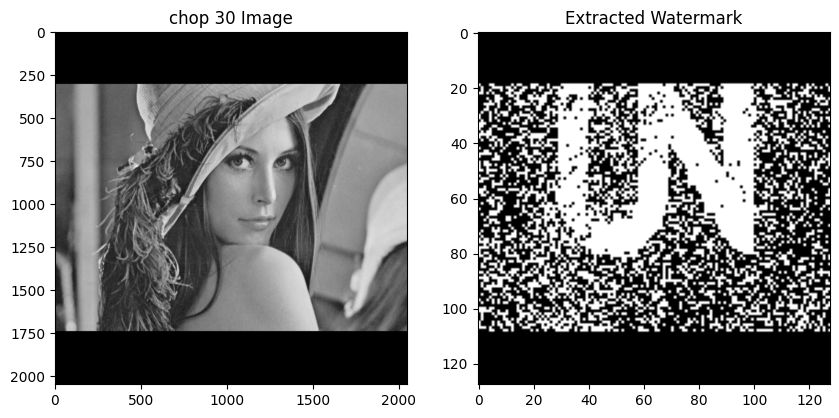

			 Normalized cross correlation is  0.9504454986118274
******************************************************************************************
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
				 Image Filtering Attacks
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


				 Gaussian Noise 
-----------------------------------------------------------------------------------------


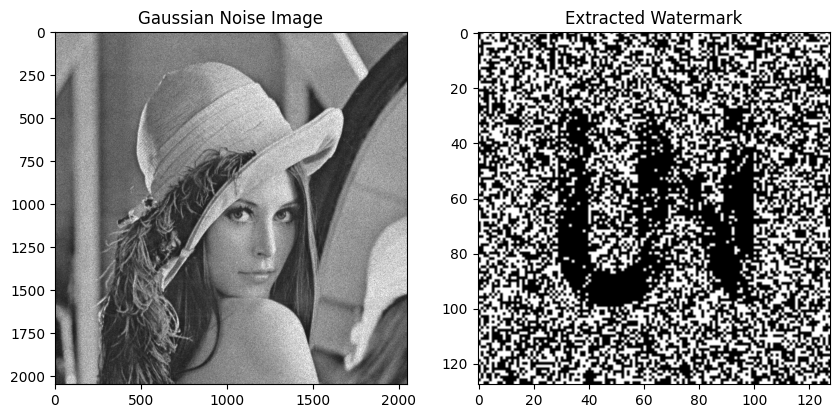

			 Normalized cross correlation is  0.9744794404267051
******************************************************************************************
				 Salt and Pepper Noise
-----------------------------------------------------------------------------------------


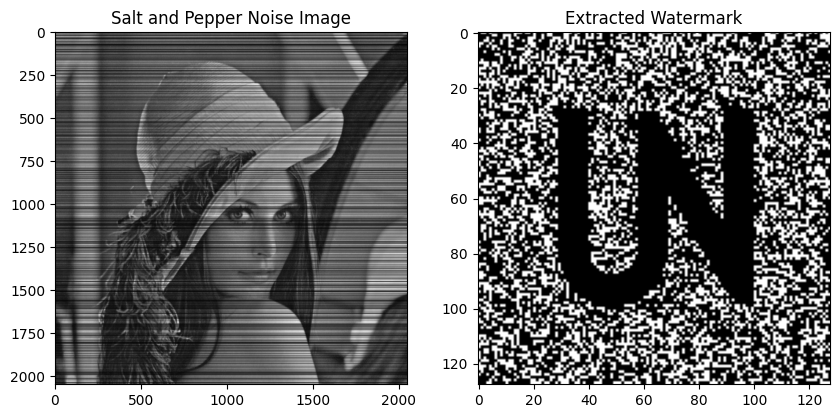

			 Normalized cross correlation is  0.9753845
******************************************************************************************
				 Poisson Noise
-----------------------------------------------------------------------------------------


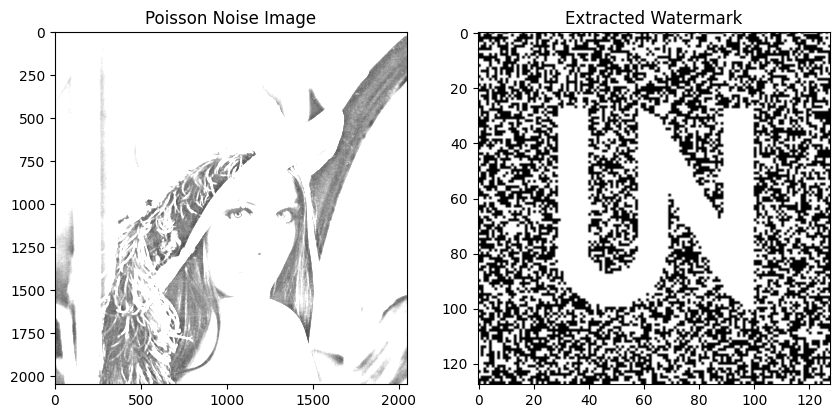

			 Normalized cross correlation is  0.9480533003885551
******************************************************************************************
				 Speckle Noise
-----------------------------------------------------------------------------------------


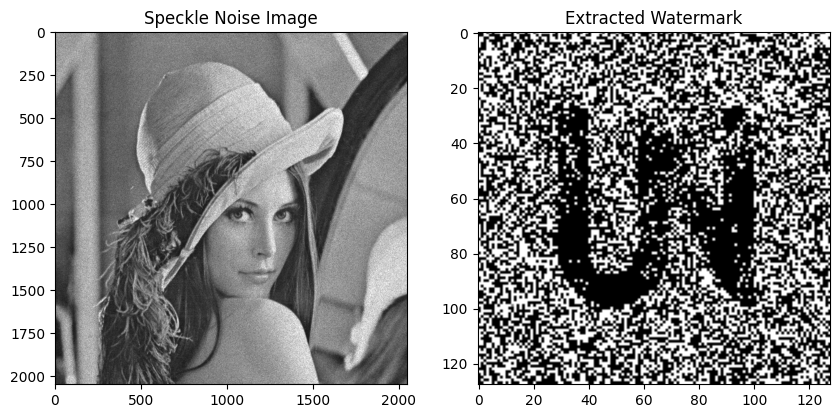

			 Normalized cross correlation is  0.9740244014499198
******************************************************************************************


In [455]:
originalImage = cv2.imread("original/image.jpg", cv2.IMREAD_GRAYSCALE)
originalImage = cv2.resize(originalImage, (512, 512))
originalMarque = cv2.imread("original/marque.jpg", cv2.IMREAD_GRAYSCALE)

watermarked = cv2.imread("result/watermarkedImage.jpg")
watermarked = cv2.cvtColor(watermarked, cv2.COLOR_BGR2YCrCb)
watermarked = watermarked.astype(np.float32)
y = watermarked[:,:,0]
Cb = watermarked[:,:,1]
Cr = watermarked[:,:,2]
# Select the channel
watermarked = y

""" watermarked = embeddedImage(image,marque) 
# Convert to numpy and grayscale
watermarked = np.array(watermarked)
watermarked = cv2.cvtColor(watermarked, cv2.COLOR_BGR2GRAY) """

#extracted = cv2.imread("result/recoveredWatermark.png", cv2.IMREAD_GRAYSCALE)

print ('+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++')
print ('\t\t\t\t Compression Attacks')
print ('+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++\n\n')
img = noisy( "jpeg",watermarked)
extracted = recoverWatermark(img, "jpeg")
plt.figure(figsize = (10,10))
plt.subplot(1,2,1), plt.imshow(img, cmap = 'gray', vmin = 0, vmax = 255), plt.title("Jpeg 50% Image")
plt.subplot(1,2,2), plt.imshow(extracted, cmap = 'gray', vmin = 0, vmax = 255), plt.title("Extracted Watermark")
plt.show()

print ('+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++')
print ('\t\t\t\t Geometric Attacks')
print ('+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++\n\n')

print ("\t\t\t\t Rotate 90°")
print ("-----------------------------------------------------------------------------------------")
img = noisy( "rotate90",watermarked)
extracted = recoverWatermark(img, "rotate90")
plt.figure(figsize = (10,10))
plt.subplot(1,2,1), plt.imshow(img, cmap = 'gray', vmin = 0, vmax = 255), plt.title("Rotate 90° Image")
plt.subplot(1,2,2), plt.imshow(extracted, cmap = 'gray', vmin = 0, vmax = 255), plt.title("Extracted Watermark")
plt.show()
print ("\t\t\t Normalized cross correlation is ", NCC(pastingImage(originalImage,img),img))
print ("******************************************************************************************")
print ("\t\t\t\t Chop 30")
print ("-----------------------------------------------------------------------------------------")
img = noisy( "chop30",watermarked)
img = restoreCrop(img)
extracted = (recoverWatermark(img, "crop")) # Image.fromarray(recoverWatermark(img))
plt.figure(figsize = (10,10))
plt.subplot(1,2,1), plt.imshow(img, cmap = 'gray', vmin = 0, vmax = 255), plt.title("chop 30 Image")
plt.subplot(1,2,2), plt.imshow(extracted, cmap = 'gray', vmin = 0, vmax = 255), plt.title("Extracted Watermark")
plt.show()
print ("\t\t\t Normalized cross correlation is ", NCC(pastingImage(originalImage,img),img))
print ("******************************************************************************************")

print ('+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++')
print ('\t\t\t\t Image Filtering Attacks')
print ('+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++\n\n')

print ("\t\t\t\t Gaussian Noise ")
print ("-----------------------------------------------------------------------------------------")
img = noisy( "gauss",watermarked)
extracted = (recoverWatermark(img, "noisy"))
plt.figure(figsize = (10,10))
plt.subplot(1,2,1), plt.imshow(img, cmap = 'gray', vmin = 0, vmax = 255), plt.title("Gaussian Noise Image")
plt.subplot(1,2,2), plt.imshow(extracted, cmap = 'gray', vmin = 0, vmax = 255), plt.title("Extracted Watermark")
plt.show()
print ("\t\t\t Normalized cross correlation is ", NCC(pastingImage(originalImage,img),img))
print ("******************************************************************************************")

print ("\t\t\t\t Salt and Pepper Noise")
print ("-----------------------------------------------------------------------------------------")
img = noisy( "s&p",watermarked)
extracted = (recoverWatermark(img, "s&p"))
plt.figure(figsize = (10,10))
plt.subplot(1,2,1), plt.imshow(img, cmap = 'gray', vmin = 0, vmax = 255), plt.title("Salt and Pepper Noise Image")
plt.subplot(1,2,2), plt.imshow(extracted, cmap = 'gray', vmin = 0, vmax = 255), plt.title("Extracted Watermark")
plt.show()
print ("\t\t\t Normalized cross correlation is ", NCC(pastingImage(originalImage,img),img))
print ("******************************************************************************************")

print ("\t\t\t\t Poisson Noise")
print ("-----------------------------------------------------------------------------------------")
img = noisy( "poisson",watermarked)
extracted = (recoverWatermark(img, "poisson"))
plt.figure(figsize = (10,10))
plt.subplot(1,2,1), plt.imshow(img, cmap = 'gray', vmin = 0, vmax = 255), plt.title("Poisson Noise Image")
plt.subplot(1,2,2), plt.imshow(extracted, cmap = 'gray', vmin = 0, vmax = 255), plt.title("Extracted Watermark")
plt.show()
print ("\t\t\t Normalized cross correlation is ", NCC(pastingImage(originalImage, img), img))
print ("******************************************************************************************")

print ("\t\t\t\t Speckle Noise")
print ("-----------------------------------------------------------------------------------------")
img = noisy( "speckle",watermarked)
extracted = (recoverWatermark(img, "speckle"))
plt.figure(figsize = (10,10))
plt.subplot(1,2,1), plt.imshow(img, cmap = 'gray', vmin = 0, vmax = 255), plt.title("Speckle Noise Image")
plt.subplot(1,2,2), plt.imshow(extracted, cmap = 'gray', vmin = 0, vmax = 255), plt.title("Extracted Watermark")
plt.show()
print ("\t\t\t Normalized cross correlation is ", NCC(pastingImage(originalImage, img), img))
print ("******************************************************************************************")